# Implementation of Convolutional Encoder and Decoder for Bit-rate $\approx\frac{1}{2}$ with 2-PAM Modulation Scheme

Video References:
1. [Introduction to Convolutional Encoder](https://www.youtube.com/watch?v=AnyVu5eDhAQ&t=2734s)
2. [Viterbi Decoder](https://www.youtube.com/watch?v=z1MdvYu2ZHk&t=2171s)

The following implementation is done for Bit-Rate $\approx \frac{1}{2}$. The Convolutional Encoder is written for desired for any no.of Memory Units but The Convolutional Decoder, implemented using Viterbi's Algorithm is done for 2 Memory Units for simplicity.

## Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from skimage.color import rgb2gray
from PIL import Image
import math
from sklearn.metrics import mean_squared_error

## Binary Image

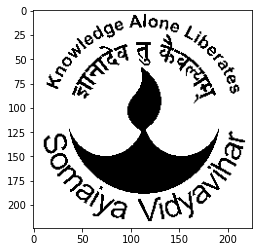

In [146]:
Data = np.load('./data/somaiya.npy')
plt.imshow(Data,cmap='gray')

In [147]:
Data.shape

(224, 225)

In [148]:
Data.shape[0] * Data.shape[1]

50400

### Parameters

In [149]:
Variance = 10
N = 50
T = 1e-3
fc = 20000
mu = 2
n = 2

## Convolutional Encoder

Specification of Block Diagram:
1. No.of Input Bits = 1
2. No.of Outputs Bits($n$) = 2
3. No.of Memory Units($\mu$) = 2

So, for a $k$ input bits we will get
$N = n(k+\mu)$ output bits.

For $\mu = 2$,
Data stored in Memory Elements is none other than $x[n-1]$ and $x[n-2]$ respectively from left to right.

#### **Image of Convolutional Encoder with 2 Memory Units**
<img src="./Images/Convolutional_Encoder_mu=2_Type-1.png">


In [150]:
def ConvEncoder(BitStream,mu,n):
    k = BitStream.shape[0]
    TeriBits = np.zeros(mu,)
    U = np.zeros((mu,),dtype=int)
    OutputStream = np.zeros(((k+mu),2))

    Input = np.append(BitStream,TeriBits)

    for i in range(Input.shape[0]):
        a = U[0]
        b = U[1]
        c = int(Input[i])

        v1 = c ^ a
        v2 = c ^ a ^ b
        OutputStream[i] = np.array([v2,v1])
        
        U[0] = c
        U[1] = a

    return OutputStream

In [151]:
EncodedStream = ConvEncoder(Data.flatten(),mu,n)

## Modulation Scheme

Applying 2-PAM Modulation on Data Stream.

In [152]:
def PAM2Encoder(EncodedStream):
    S1 = np.where(EncodedStream == 1,EncodedStream, -1)
    return S1

In [153]:
ModulatedStream = PAM2Encoder(EncodedStream)

## Transmission

Transmitting Signal as $\sqrt2 cos(2\pi f_{c}t)$ and $-\sqrt2 cos(2\pi f_{c}t)$ for a span of $T$ seconds. Energy of Transmitted Signals are equal to $T$

In [154]:
def Transmission(ModulatedStream,T,fc,N):
    S = np.sqrt(2)*np.cos(2*np.pi*fc*np.linspace(0,T,N))
    l,m = ModulatedStream.shape
    n = S.shape[0]
    Output = np.zeros((l,m,n))

    for i in range(l):
        for j in range(m):
            Output[i][j] = ModulatedStream[i][j] * S

    return Output

In [155]:
TransmittedStream = Transmission(ModulatedStream,T,fc,N)

## Receiving Data

AWGN (Additive White Gaussian Noise) is added to Transmitted Signals

In [156]:
def ReceivingData(TransmittedStream,Variance):
    l,m,n = TransmittedStream.shape
    Output = np.zeros(TransmittedStream.shape)
    for i in range(l):
        for j in range(m):
            Output[i][j] = TransmittedStream[i][j] + np.random.normal(0,np.sqrt(Variance),size=n)

    return Output

In [157]:
ReceivedStream = ReceivingData(TransmittedStream,Variance)

## DeModulation

Obtained Waveforms are DeModulated.

In [158]:
def PAM2Waveforms(T,N,fc):
    Waveforms = np.zeros((2,N))

    Waveforms[0] = -np.sqrt(2)*np.cos(2*np.pi*fc*np.linspace(0,T,N))
    Waveforms[1] = np.sqrt(2)*np.cos(2*np.pi*fc*np.linspace(0,T,N))

    return Waveforms

Waveforms = PAM2Waveforms(T,N,fc)

In [159]:
def DeModulation(ReceivedStream,Waveforms):

    Output = np.zeros((ReceivedStream.shape[0],ReceivedStream.shape[1]))

    for i in range(ReceivedStream.shape[0]):
        for j in range(ReceivedStream.shape[1]):
            Output[i][j] = np.argmin(np.sum(np.multiply((ReceivedStream[i][j] - Waveforms),(ReceivedStream[i][j] - Waveforms)),axis=1))

    return Output           

In [160]:
DeModulatedStream = DeModulation(ReceivedStream,Waveforms)

Error between Demodulated Stream and Encoded Stream

In [161]:
np.sum(np.abs(DeModulatedStream-EncodedStream))

1217.0

## Viterbi Decoding for $\mu = 2$

The decoding algorithm uses two metrics: the Branch Metric (BM) and the Path Metric
(PM). The branch metric is a measure of the “distance” between what was transmitted and
what was received, and is defined for each arc in the trellis. In hard decision decoding,
where we are given a sequence of digitized parity bits, the branch metric is the Hamming
distance between the expected parity bits and the received ones.

The key insight in the Viterbi algorithm is that the receiver can compute the path metric
for a (state, time) pair incrementally using the path metrics of previously computed states
and the branch metrics.

For every s in $2^k$ states, Path Metric at time instant i is calculated as follows:

$\operatorname{PM}[s, i]=\min (\operatorname{PM}[\alpha, i-1]+\operatorname{BM}[\alpha \rightarrow s], \operatorname{PM}[\beta, i-1]+\operatorname{BM}[\beta \rightarrow s])$

In [162]:
def HammingDistance(a,b):
    return np.sum(np.square(a-b))

In [163]:
def ViterbiDecoder(DeModulatedStream,mu):
    # Look-up Table for State Machine
    '''
    # State Table in Lecture Videos (Type-2)
    State_Table = [
            [0, 0, [0,0], 0],
            [0, 0, [1,1], 1],
            [1, 0, [1,0], 2],
            [1, 0, [0,1], 3],
            [2, 1, [1,1], 0],
            [2, 1, [0,0], 1],
            [3, 1, [0,1], 2],
            [3, 1, [1,0], 3]
    ]
    '''
    
    # MIT's State Table (Type-1)
    State_Table = [
            [0, 0, [0,0], 0],
            [0, 0, [1,0], 1],
            [1, 0, [1,1], 2],
            [1, 0, [0,1], 3],
            [2, 1, [1,1], 0],
            [2, 1, [0,1], 1],
            [3, 1, [0,0], 2],
            [3, 1, [1,0], 3]
    ]

    m = DeModulatedStream.shape[0]
    k = pow(2,mu)

    # Branch Metric is Hamming Distance.
    Path_Metric = np.zeros((k,m+1))
    Path_Metric[1:4,0] = 1e6 * np.ones((3,))

    # Creating Path Metrics.
    for i in range(1,m+1):
        for j in range(k):
            BM1 = HammingDistance(DeModulatedStream[i-1],State_Table[2*j][2])
            BM2 = HammingDistance(DeModulatedStream[i-1],State_Table[2*j + 1][2])
            V1 = Path_Metric[State_Table[2*j][3]][i-1] + BM1
            V2 = Path_Metric[State_Table[2*j + 1][3]][i-1] + BM2
            
            Path_Metric[j][i] = min(V1,V2)
    
    Output = []
    
    ind = np.argmin(Path_Metric[:,i])    
    for i in reversed(range(1,m+1)):
        a = State_Table[2*ind][3]
        b = State_Table[2*ind + 1][3]
        if (Path_Metric[:,i-1][a] <= Path_Metric[:,i-1][b]):
            ind_prev = a
        else:
            ind_prev = b
            
        for j in range(len(State_Table)):
            if (State_Table[j][0] == ind and State_Table[j][3] == ind_prev):
                Output.append(State_Table[j][1])
        ind = ind_prev
                
    Output.reverse()
    
    Output.pop()
    Output.pop()
    return np.array(Output)

In [164]:
DecodedStream = ViterbiDecoder(DeModulatedStream,mu)

Calculating Error Bits and Percentage

In [165]:
ErrorBits = np.sum(np.abs(DecodedStream - Data.flatten()))
ErrorBits

115

In [166]:
Percentage = (1 - ErrorBits/DecodedStream.shape[0]) * 100
Percentage

99.77182539682539

## Image

Image from Decoded Data

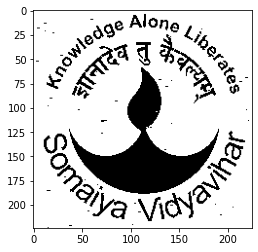

In [167]:
OutputImage = np.reshape(DecodedStream,Data.shape)
plt.imshow(OutputImage,'gray')

## BER Plot

Plotting No.of Bit Errors vs Variance

$N_{0} f_{c} = \sigma^2$


In [23]:
# For 1-bit 2 Waveforms
Eb = 2*T
Eb_per_No = np.linspace(-2,8,10,endpoint=True)
No = np.divide(Eb,np.power(10,(Eb_per_No/10)))
Variance_List = No*fc

BER_List = []

EncodedStream = ConvEncoder(Data.flatten(),mu,n)
ModulatedStream = PAM2Encoder(EncodedStream)
TransmittedStream = Transmission(ModulatedStream,T,fc,N)

# Noise is added at the Receiver's End
for Variance in Variance_List:
    ReceivedStream = ReceivingData(TransmittedStream,Variance)
    DeModulatedStream = DeModulation(ReceivedStream,Waveforms)
    DecodedStream = ViterbiDecoder(DeModulatedStream,mu)
    ErrorBits = np.sum(np.abs(DecodedStream - Data.flatten()))
    BER_List.append(ErrorBits/DecodedStream.shape[0])

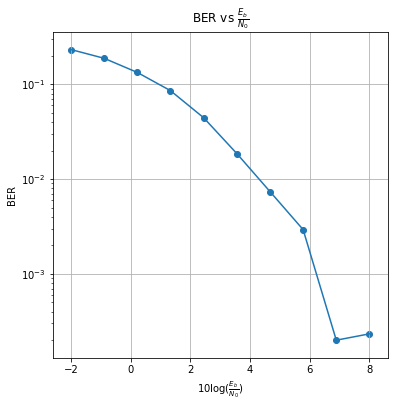

In [24]:
plt.figure(figsize=(6,6))
plt.semilogy(Eb_per_No,BER_List)
plt.title(r'BER vs $\frac{E_{b}}{N_{0}}$')
plt.xlabel(r'$10\log(\frac{E_{b}}{N_{0}})$')
plt.ylabel(r'BER')
plt.grid(axis='both')
plt.scatter(Eb_per_No,BER_List)
plt.savefig('./Images/BER_Type-1.png')
plt.show()